In [1]:
import os
import sys
import mxnet as mx
import skimage.io
import argparse
import importlib

In [2]:
sys.path.append(os.path.join(os.getcwd(),'dataset'))
from detect.detector import Detector

In [3]:
CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

In [4]:
def get_detector(net, prefix, epoch, data_shape, mean_pixels, ctx,
                 nms_thresh=0.5, force_nms=True):
    """
    wrapper for initialize a detector

    Parameters:
    ----------
    net : str
        test network name
    prefix : str
        load model prefix
    epoch : int
        load model epoch
    data_shape : int
        resize image shape
    mean_pixels : tuple (float, float, float)
        mean pixel values (R, G, B)
    ctx : mx.ctx
        running context, mx.cpu() or mx.gpu(?)
    force_nms : bool
        force suppress different categories
    """
    sys.path.append(os.path.join(os.getcwd(), 'symbol'))
    net = importlib.import_module("symbol_" + net) \
        .get_symbol(len(CLASSES), nms_thresh, force_nms)
    detector = Detector(net, prefix + "_" + str(data_shape), epoch, \
        data_shape, mean_pixels, ctx=ctx)
    return detector

In [5]:
def default_args():
    parser = argparse.ArgumentParser(description='Single-shot detection network demo')
    parser.add_argument('--network', dest='network', type=str, default='vgg16_reduced',
                        choices=['vgg16_reduced'], help='which network to use')
    parser.add_argument('--images', dest='images', type=str, default='dog,person',
                        help='run demo with images, use comma(without space) to seperate multiple images')
    parser.add_argument('--dir', dest='dir', nargs='?',default ='./data/demo/',
                        help='demo image directory, optional', type=str)
    parser.add_argument('--ext', dest='extension', default='.jpg',
                        help='image extension, optional',type=str, nargs='?')
    parser.add_argument('--epoch', dest='epoch', help='epoch of trained model',
                        default=0, type=int)
    parser.add_argument('--prefix', dest='prefix', help='trained model prefix',
                        default=os.path.join(os.getcwd(), 'model', 'ssd'), type=str)
    parser.add_argument('--cpu', dest='cpu', help='(override GPU) use CPU to detect',
                        action='store_true', default=False)
    parser.add_argument('--gpu', dest='gpus', type=str, default='-1',
                        help='GPU device id to detect with')
    parser.add_argument('--data-shape', dest='data_shape', type=int, default=300,
                        help='set image shape')
    parser.add_argument('--mean-r', dest='mean_r', type=float, default=123,
                        help='red mean value')
    parser.add_argument('--mean-g', dest='mean_g', type=float, default=117,
                        help='green mean value')
    parser.add_argument('--mean-b', dest='mean_b', type=float, default=104,
                        help='blue mean value')
    parser.add_argument('--thresh', dest='thresh', type=float, default=0.5,
                        help='object visualize score threshold, default 0.6')
    parser.add_argument('--nms', dest='nms_thresh', type=float, default=0.5,
                        help='non-maximum suppression threshold, default 0.5')
    parser.add_argument('--force', dest='force_nms', type=bool, default=True,
                        help='force non-maximum suppression on different class')
    parser.add_argument('--timer', dest='show_timer', type=bool, default=True,
                        help='show detection time')
    return parser

In [6]:
args = default_args().parse_args(args='')
if args.gpus=='-1':
    ctx = [mx.cpu()]
else:
    ctx = [mx.gpu(int(i)) for i in args.gpus.split(',')]
# parse image list
image_list = [i.strip() for i in args.images.split(',')]
assert len(image_list) > 0, "No valid image specified to detect"

Detection time for 2 images: 8.9684 sec


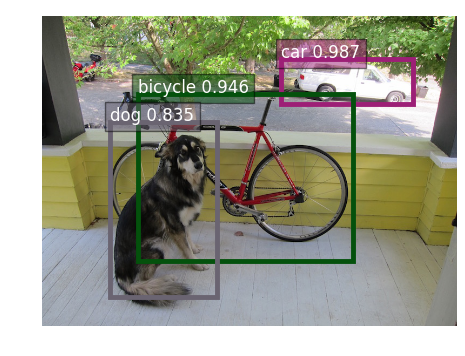

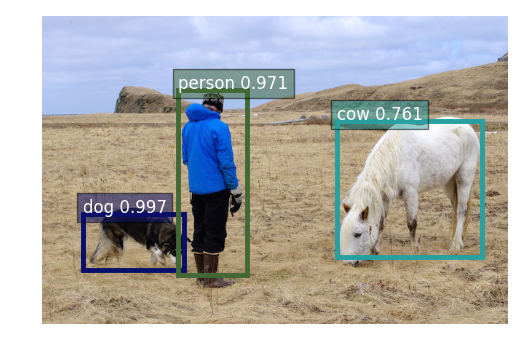

In [7]:
detector = get_detector(args.network, args.prefix, args.epoch,
                        args.data_shape,
                        (args.mean_r, args.mean_g, args.mean_b),
                        ctx, args.nms_thresh, args.force_nms)
# run detection
detector.detect_and_visualize(image_list, args.dir, args.extension,
                               CLASSES, args.thresh, args.show_timer)